Translate one Wikidata object and upload with QuickStatements

In [1]:
import time
start_time = time.time()


In [13]:
from datetime import datetime
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

def count_labels_by_language():
    """
    Counts the number of  have labels

    Parameters:

    Returns:
        List[Dict]: A list of dictionaries with keys 'lang' and 'count'
    """
    print (f"count_labels_by_language - SAT")
    endpoint_url = "https://query.wikidata.org/sparql"

    query = f"""
    SELECT ?lang (count(?item) AS ?count) WHERE {{
        VALUES   ?item {{wd:Q135400223}} 
        wd:Q135400223 
        rdfs:label ?label.
        BIND(LANG(?label) AS ?lang)
    }}
    GROUP BY ?lang
    ORDER BY DESC (?count)
    """

    user_agent = f"SAT-LabelCounter-Python/{sys.version_info[0]}.{sys.version_info[1]}"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    return [
        {"lang": result["lang"]["value"], "count": int(result["count"]["value"])}
        for result in results["results"]["bindings"]
    ]


In [14]:
data = count_labels_by_language()

count_labels_by_language - SAT


In [15]:
data


[{'lang': 'en', 'count': 1}, {'lang': 'sv', 'count': 1}]

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_language_distribution(data):
    """
    Plots a pie and bar chart of language distribution side by side.

    Parameters:
    - data: List[Dict[str, Any]] — a list of dictionaries with keys 'lang' and 'count'.
    """
    # Prepare data for plotting
    labels = [entry["lang"] for entry in data]
    sizes = [entry["count"] for entry in data]

    # Current timestamp
    today_str = datetime.now().strftime("%Y-%m-%d %H:%M")
    title = f"SAT — {today_str}"

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Pie chart
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax1.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
    ax1.set_title(f'Language Distribution (Pie)\n{title}')

    # Bar chart
    ax2.bar(labels, sizes)
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, rotation=90)
    ax2.set_ylabel('Count')
    ax2.set_title(f'Language Count (Bar)\n{title}')

    plt.tight_layout()
    plt.show()


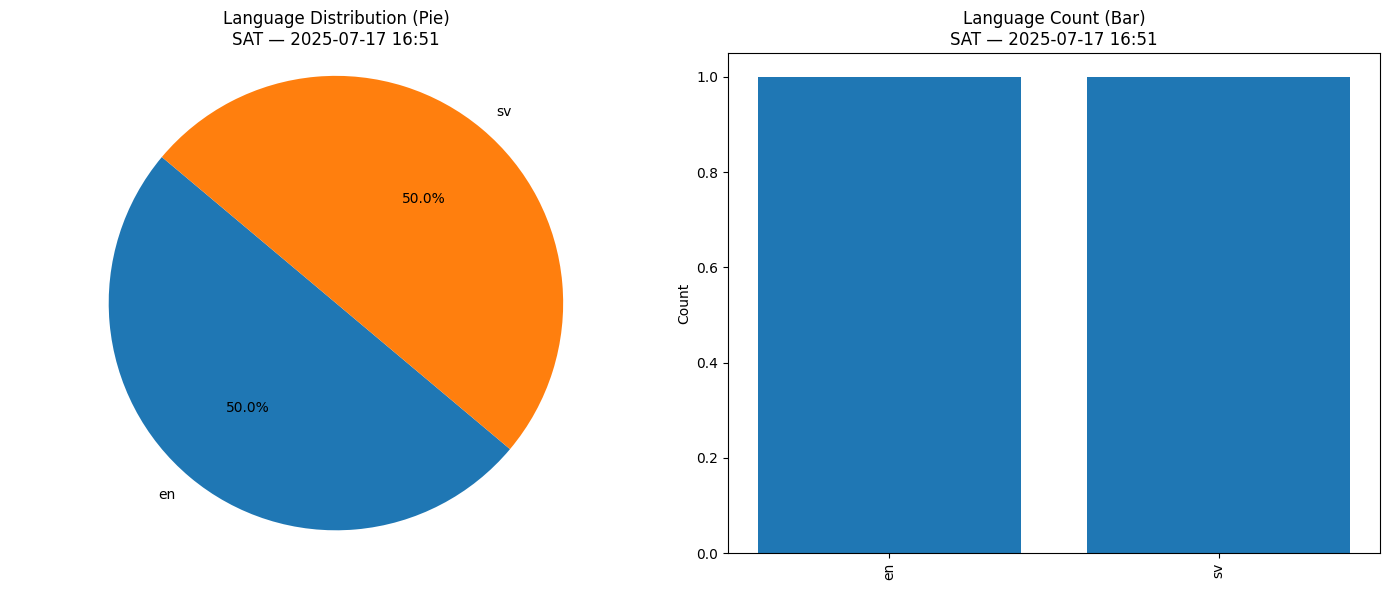

In [17]:

plot_language_distribution(data)


In [18]:

from deep_translator import GoogleTranslator

# Build language support set from name → code mapping
lang_name_to_code = GoogleTranslator().get_supported_languages(as_dict=True)
supported_lang_codes = set(lang_name_to_code.values())

# Track which languages we've already logged
unsupported_warned = set()
supported_logged = set()

def translate_label(label_sv, target_lang):
    """
    Translate a label from Swedish to the target language if supported by Google Translate.
    Logs support status the first time each language is encountered.

    Returns:
        str or None: The translated label, or None if unsupported or failed.
    """
    if target_lang not in supported_lang_codes:
        if target_lang not in unsupported_warned:
            print(f"❌ Google Translate does NOT support: '{target_lang}' — skipping")
            unsupported_warned.add(target_lang)
        return None
    else:
        if target_lang not in supported_logged:
            print(f"✅ Google Translate supports: '{target_lang}'")
            supported_logged.add(target_lang)

    try:
        return GoogleTranslator(source='sv', target=target_lang).translate(label_sv)
    except Exception as e:
        print(f"⚠️ Translation error for '{target_lang}': {e}")
        return None
